In [1]:
import ete3
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%cd '/work/nif/'
%matplotlib inline

/work/nif


In [2]:
proteo       = pd.read_table('proteo_info.tab', index_col=0)
species_tree = ete3.Tree('species.tre', format=1)
nif_tree     = ete3.Tree('nifHDKENB_concat/concatenated_partitions.treefile', format=1)

for leaf in nif_tree.get_leaves():
    leaf.name = str(proteo.loc[leaf.name, 'taxid'])

nif_genomes = set(nif_tree.get_leaf_names())
species_tree.prune(nif_genomes)

In [3]:
indexes = []
for edge in species_tree.get_edges():
    if len(edge[0]) <= 1 or len(edge[1]) <= 1:
        continue
    index = tuple(set([leaf.name for leaf in edge_side]) for edge_side in edge)
    indexes.append(index)
species_bipartition_table = pd.DataFrame(columns='control nif'.split(), data=0.0, index=indexes)

indexes = []
for edge in nif_tree.get_edges():
    if len(edge[0]) <= 1 or len(edge[1]) <= 1:
        continue
    index = tuple(set([leaf.name for leaf in edge_side]) for edge_side in edge)
    indexes.append(index)
nif_bipartition_table = pd.DataFrame(columns='control nif'.split(), data=0.0, index=indexes)

In [6]:
#
# go through nif related genes
nif_bipartition_count = 0
for group in os.listdir('mad_reconciliations/'):
    gene_tree = ete3.Tree(open('mad_reconciliations/%s/%s.ranger_input' % (group, group)).readlines()[1])
    genomes   = []
    for leaf in gene_tree.get_leaves():
        genome, gene = leaf.name.split('_')
        leaf.add_feature('gene_name', gene)
        if genome in nif_genomes:
            genomes.append(leaf.name)
    
    gene_tree.prune(genomes)

    
    for edge in gene_tree.get_edges():
        if len(edge[0]) <= 1 or len(edge[1]) <= 1:
            continue
        nif_bipartition_count += 1
        gene_split = [set([leaf.name.split('_')[0] for leaf in edge_side]) for edge_side in edge]
        
        incompatible_splits = []
        for species_split in species_bipartition_table.index:
            if species_split in incompatible_splits:
                continue
            if (gene_split[0].issubset(  species_split[0]) or
                gene_split[0].issuperset(species_split[0]) or
                gene_split[0].issubset(  species_split[1]) or 
                gene_split[0].issuperset(species_split[1])):
                continue
            else:
                species_bipartition_table.loc[species_bipartition_table.index == species_split, 'nif'] += 1
                incompatible_splits.append(species_split)

        incompatible_splits = []
        for nif_split in nif_bipartition_table.index:
            if nif_split in incompatible_splits:
                continue
            if (gene_split[0].issubset(  nif_split[0]) or
                gene_split[0].issuperset(nif_split[0]) or
                gene_split[0].issubset(  nif_split[1]) or 
                gene_split[0].issuperset(nif_split[1])):
                continue
            else:
                nif_bipartition_table.loc[nif_bipartition_table.index == nif_split, 'nif'] += 1
                incompatible_splits.append(nif_split)

In [7]:
#
# go through control genes
control_bipartition_count = 0
for group in os.listdir('control_reconciliations/'):
    if not os.path.isfile('control_reconciliations/%s/%s.ranger_input' % (group, group)):
        continue

    gene_tree = ete3.Tree(open('control_reconciliations/%s/%s.ranger_input' % (group, group)).readlines()[1])
    genomes   = []
    for leaf in gene_tree.get_leaves():
        genome, gene = leaf.name.split('_')
        leaf.add_feature('gene_name', gene)
        if genome in nif_genomes:
            genomes.append(leaf.name)
    
    gene_tree.prune(genomes)

    
    for edge in gene_tree.get_edges():
        if len(edge[0]) == 1 or len(edge[1]) == 1:
            continue
        control_bipartition_count += 1
        gene_split = [set([leaf.name.split('_')[0] for leaf in edge_side]) for edge_side in edge]
        
        incompatible_splits = []
        for species_split in species_bipartition_table.index:
            if species_split in incompatible_splits:
                continue
            if (gene_split[0].issubset(  species_split[0]) or
                gene_split[0].issuperset(species_split[0]) or
                gene_split[0].issubset(  species_split[1]) or 
                gene_split[0].issuperset(species_split[1])):
                continue
            else:
                species_bipartition_table.loc[species_bipartition_table.index == species_split, 'control'] += 1
                incompatible_splits.append(species_split)

        incompatible_splits = []
        for nif_split in nif_bipartition_table.index:
            if nif_split in incompatible_splits:
                continue
            if (gene_split[0].issubset(  nif_split[0]) or
                gene_split[0].issuperset(nif_split[0]) or
                gene_split[0].issubset(  nif_split[1]) or 
                gene_split[0].issuperset(nif_split[1])):
                continue
            else:
                nif_bipartition_table.loc[nif_bipartition_table.index == nif_split, 'control'] += 1
                incompatible_splits.append(nif_split)

In [10]:
print nif_bipartition_count
print control_bipartition_count
nif_bipartition_table.head()

1913
6006


,control,nif
"({391038, 266265, 269482, 977880}, {883, 880072, 944547, 526222, 592316, 460265, 272942, 349124, 159087, 622759, 366394, 338963, 272568, 347834, 216596, 439235, 395963, 395960, 1151116, 522306, 507522, 395965, 243159, 273121, 62928, 640081, 572477, 862719, 377629, 198628, 573370, 438753, 218491, 1037409, 595494, 983917, 269796, 757424, 765698, 648757, 765911, 365044, 78245, 243233, 577650, 426117, 394, 641491, 342108, 156889, 709032, 589865, 1116375, 137722, 266835, 690850, 1150469, 717785, 177437, 557760, 580332, 572480, 640131, 706587, 525897, 707241, 644282, 335543, 1006551, 288000, 743299, 760154, 1064539, 536019, 857087, 643562, 996285, 395495, 322710})",858.0,218.0
"({266265, 269482}, {883, 880072, 216596, 944547, 526222, 592316, 460265, 272942, 349124, 159087, 622759, 366394, 338963, 272568, 347834, 977880, 439235, 395963, 395960, 1151116, 522306, 507522, 395965, 243159, 273121, 62928, 640081, 572477, 862719, 377629, 198628, 573370, 438753, 218491, 1037409, 595494, 983917, 269796, 757424, 765698, 648757, 765911, 365044, 78245, 243233, 577650, 426117, 394, 641491, 342108, 156889, 709032, 589865, 1116375, 137722, 266835, 690850, 1150469, 717785, 177437, 557760, 580332, 572480, 640131, 706587, 525897, 707241, 644282, 335543, 1006551, 288000, 743299, 760154, 1064539, 536019, 857087, 643562, 996285, 395495, 322710, 391038})",590.0,88.0
"({391038, 977880}, {883, 880072, 944547, 526222, 592316, 460265, 272942, 349124, 159087, 622759, 366394, 338963, 272568, 347834, 216596, 439235, 395963, 395960, 1151116, 522306, 507522, 757424, 395965, 243159, 273121, 62928, 640081, 572477, 862719, 377629, 198628, 573370, 438753, 218491, 1037409, 595494, 983917, 269796, 266265, 765698, 648757, 765911, 365044, 78245, 243233, 577650, 426117, 394, 641491, 342108, 156889, 709032, 589865, 1116375, 137722, 266835, 690850, 1150469, 717785, 177437, 557760, 580332, 395495, 572480, 640131, 706587, 525897, 707241, 644282, 335543, 1006551, 288000, 743299, 760154, 1064539, 536019, 857087, 643562, 996285, 269482, 322710})",708.0,104.0
"({525897, 643562, 641491, 526222}, {883, 880072, 216596, 944547, 322710, 592316, 460265, 272942, 349124, 159087, 622759, 366394, 338963, 272568, 347834, 977880, 439235, 395963, 395960, 1151116, 522306, 507522, 757424, 395965, 243159, 273121, 62928, 640081, 572477, 862719, 377629, 198628, 573370, 438753, 218491, 1037409, 595494, 983917, 269796, 266265, 765698, 648757, 765911, 365044, 78245, 243233, 577650, 426117, 394, 342108, 156889, 709032, 589865, 1116375, 137722, 266835, 690850, 1150469, 717785, 177437, 557760, 580332, 395495, 572480, 640131, 706587, 707241, 644282, 335543, 1006551, 288000, 743299, 760154, 1064539, 536019, 857087, 996285, 269482, 391038})",892.0,58.0
"({198628, 640131, 592316, 1006551, 218491, 507522}, {883, 880072, 944547, 526222, 460265, 272942, 216596, 159087, 622759, 366394, 338963, 272568, 347834, 977880, 439235, 395963, 395960, 522306, 577650, 757424, 395965, 243159, 273121, 62928, 640081, 572477, 862719, 377629, 573370, 438753, 1037409, 595494, 983917, 269796, 266265, 765698, 648757, 349124, 765911, 365044, 78245, 243233, 426117, 394, 641491, 342108, 156889, 589865, 1116375, 137722, 266835, 690850, 1150469, 717785, 709032, 557760, 580332, 395495, 572480, 177437, 706587, 525897, 707241, 644282, 335543, 1151116, 288000, 743299, 760154, 1064539, 536019, 857087, 643562, 996285, 269482, 322710, 391038})",522.0,22.0


In [205]:
nif_bipartition_table['compatibility_ratio']    = (nif_bipartition_table.control/100.0)/(nif_bipartition_table.nif/45.0)
species_bipartition_table['compatibility_ratio'] = (species_bipartition_table.control/100.0)/(species_bipartition_table.nif/45.0)

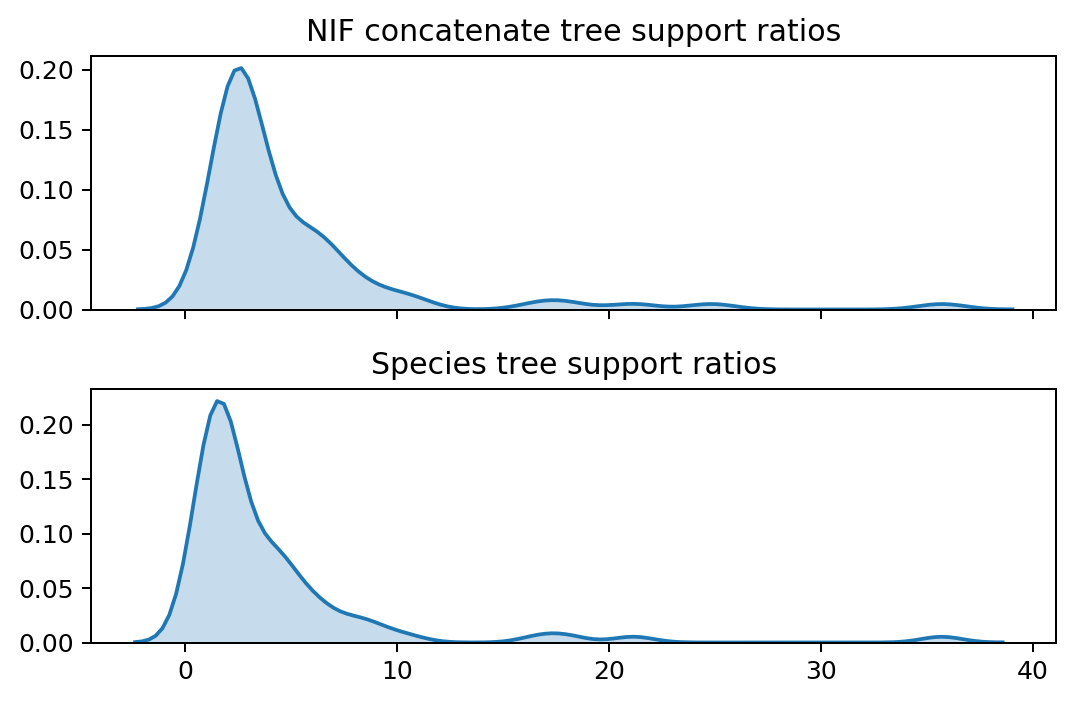

In [206]:
fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180)
sns.kdeplot(nif_bipartition_table.compatibility_ratio.values,
            shade=True, ax=axs[0])
sns.kdeplot(species_bipartition_table.compatibility_ratio.values,
            shade=True, ax=axs[1])
axs[0].set_title('NIF concatenate tree support ratios')
axs[1].set_title('Species tree support ratios')
fig.tight_layout()

In [249]:
threshold = np.percentile(nif_bipartition_table.compatibility_ratio.values, 20)
greater_nif_support = nif_bipartition_table[nif_bipartition_table.compatibility_ratio < threshold]

incompatible_with_species = []
for nif_split in greater_nif_support.index:
    for species_split in species_bipartition_table.index:
        if (nif_split[0].issubset(  species_split[0]) or
            nif_split[0].issuperset(species_split[0]) or
            nif_split[0].issubset(  species_split[1]) or 
            nif_split[0].issuperset(species_split[1])):
            continue
        else:
            incompatible_with_species.append(nif_split)
            break

for split in greater_nif_support.index:
    leaves = split[0]
    if len(split[0]) > len(split[1]):
        leaves = split[1]
    
    print proteo[proteo.taxid.isin(leaves)].index.tolist()
    print proteo[proteo.taxid.isin(leaves)]['class'].tolist()
    print ''

['Azorhizobium_caulinodans', 'Xanthobacter_autotrophicus']
['Alphaproteobacteria', 'Alphaproteobacteria']

['Azorhizobium_caulinodans', 'Beijerinckia_indica', 'Bradyrhizobium_japonicum', 'Bradyrhizobium_sp', 'Hyphomicrobium_sp', 'Methylocella_silvestris', 'Methylococcus_capsulatus', 'Rhodomicrobium_vannielii', 'Rhodopseudomonas_palustris', 'Xanthobacter_autotrophicus']
['Alphaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria', 'Gammaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria', 'Alphaproteobacteria']

['Acidithiobacillus_ferrivorans', 'Acidithiobacillus_ferrooxidans', 'Azorhizobium_caulinodans', 'Beijerinckia_indica', 'Bradyrhizobium_japonicum', 'Bradyrhizobium_sp', 'Hyphomicrobium_sp', 'Methylocella_silvestris', 'Methylococcus_capsulatus', 'Rhodomicrobium_vannielii', 'Rhodopseudomonas_palustris', 'Xanthobacter_autotrophicus']
['Gammaproteobacteria', 'Gammaproteobacteria', 'Alphaproteobacte

In [250]:
threshold = np.percentile(species_bipartition_table.compatibility_ratio.values, 80)
worse_nif_support = species_bipartition_table[species_bipartition_table.compatibility_ratio > threshold]

incompatible_with_nif = []
for species_split in worse_nif_support.index:
    for nif_split in nif_bipartition_table.index:
        if (species_split[0].issubset(  nif_split[0]) or
            species_split[0].issuperset(nif_split[0]) or
            species_split[0].issubset(  nif_split[1]) or 
            species_split[0].issuperset(nif_split[1])):
            continue
        else:
            incompatible_with_nif.append(nif_split)
            break

for split in worse_nif_support.index:
    leaves = split[0]
    if len(split[0]) > len(split[1]):
        leaves = split[1]
    
    print proteo[proteo.taxid.isin(leaves)].index.tolist()
    print proteo[proteo.taxid.isin(leaves)]['class'].tolist()
    print ''

['Klebsiella_oxytoca', 'Klebsiella_pneumoniae', 'Klebsiella_variicola']
['Gammaproteobacteria', 'Gammaproteobacteria', 'Gammaproteobacteria']

['Desulfatibacillum_alkenivorans', 'Desulfobacterium_autotrophicum']
['Deltaproteobacteria', 'Deltaproteobacteria']

['Desulfovibrio_aespoeensis', 'Desulfovibrio_desulfuricans', 'Desulfovibrio_salexigens']
['Deltaproteobacteria', 'Deltaproteobacteria', 'Deltaproteobacteria']

['Klebsiella_pneumoniae', 'Klebsiella_variicola']
['Gammaproteobacteria', 'Gammaproteobacteria']

['Desulfarculus_baarsii', 'Desulfatibacillum_alkenivorans', 'Desulfobacca_acetoxidans', 'Desulfobacterium_autotrophicum', 'Desulfobulbus_propionicus', 'Desulfomicrobium_baculatum', 'Desulfomonile_tiedjei', 'Desulfovibrio_aespoeensis', 'Desulfovibrio_africanus', 'Desulfovibrio_desulfuricans', 'Desulfovibrio_magneticus', 'Desulfovibrio_salexigens', 'Desulfovibrio_vulgaris', 'Desulfurivibrio_alkaliphilus', 'Syntrophobacter_fumaroxidans']
['Deltaproteobacteria', 'Deltaproteobacteri